In [120]:
import requests
import pandas as pd
import json
import math
import time

In [10]:
GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/negative-gamma"
def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()

In [137]:
query = """
{
  dailySnapshots(first: 1000 where: {pool: "%d"} orderBy: timestamp orderDirection: asc) {
    pool {
      name
    }
    lpTokenSupply
    reserves
    pricesUsd
    pool {
      coins
      coinDecimals
    }
    timestamp
  }
}

"""

In [91]:
def calc_lp_unit_price(reserves, decimals, prices, supply):
    tvl = sum([(int(reserve) / (10**(int(decimals[i])))) * float(prices[i]) for i, reserve in enumerate(reserves)])
    return tvl/(int(supply) * 1e-18)

In [92]:
def calc_hodl_ratios(reserves, decimals, prices, supply):
    return [int(reserve) / ((10**(int(decimals[i])))) / (int(supply) * 1e-18)   for i, reserve in enumerate(reserves)]

In [218]:
def chart_performance(pool_id):
    res = grt_query(query % pool_id)
    data = res['data']['dailySnapshots']
    returns = []
    index = 1
    while data[index]['lpTokenSupply'] == '0' and index < len(data) - 1:
        index += 1
    original_data = data[index]
    original_lp_unit_price = calc_lp_unit_price(original_data['reserves'], original_data['pool']['coinDecimals'], original_data['pricesUsd'], original_data['lpTokenSupply'])
    hodl_ratios = calc_hodl_ratios(original_data['reserves'], original_data['pool']['coinDecimals'], original_data['pricesUsd'], original_data['lpTokenSupply'])

    for i in range(index + 1, len(data)):
        current_data = data[i]
        current_lp_unit_price = calc_lp_unit_price(current_data['reserves'], current_data['pool']['coinDecimals'], current_data['pricesUsd'], current_data['lpTokenSupply'])

        hodl_value = sum([ratio * float(current_data['pricesUsd'][i]) for i, ratio in enumerate(hodl_ratios)])

        price_ratio = ((float(original_data['pricesUsd'][0]) / float(original_data['pricesUsd'][1]))) / ((float(current_data['pricesUsd'][0]) / float(current_data['pricesUsd'][1])))
        impermanent_loss = 2 * math.sqrt(price_ratio) / (1 + price_ratio) - 1
        
        sushi_lp_price = hodl_value * (1  + impermanent_loss)
        
        returns.append({'hodl': hodl_value, 'sushi_lp_price': sushi_lp_price, 'curve_lp_price': current_lp_unit_price, 'price_ratio': price_ratio, 'il': impermanent_loss, 'timestamp': int(current_data['timestamp'])})
        
    df = pd.DataFrame(returns)
    df["timestamp"] = pd.to_datetime(df["timestamp"],unit='s')
    df[['hodl', 'sushi_lp_price', 'curve_lp_price', 'timestamp']].plot(x='timestamp', figsize=(12,8), title=data[0]['pool']['name'])

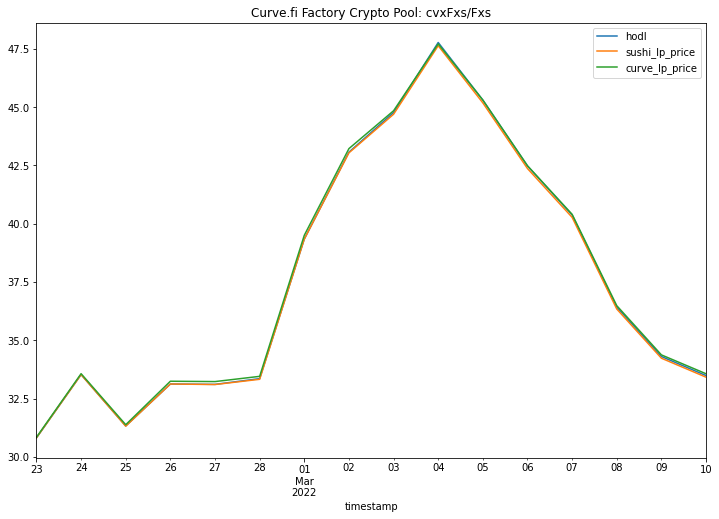

In [219]:
chart_performance(26)

In [211]:
res = grt_query(query % 26)

In [212]:
data = res['data']['dailySnapshots']
data

[{'pool': {'name': 'Curve.fi Factory Crypto Pool: cvxFxs/Fxs',
   'coins': ['0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0',
    '0xfeef77d3f69374f66429c91d732a244f074bdf74'],
   'coinDecimals': ['18', '18']},
  'lpTokenSupply': '0',
  'reserves': ['0', '0'],
  'pricesUsd': ['22.65816317567379786032751668752099',
   '20.30759376263025355462642814367925'],
  'timestamp': '1645401600'},
 {'pool': {'name': 'Curve.fi Factory Crypto Pool: cvxFxs/Fxs',
   'coins': ['0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0',
    '0xfeef77d3f69374f66429c91d732a244f074bdf74'],
   'coinDecimals': ['18', '18']},
  'lpTokenSupply': '97535648657708040125662',
  'reserves': ['39819499832113036860002', '157171423379807285338599'],
  'pricesUsd': ['19.96089457245270310892436911999119',
   '16.76305418443233888556353625972218'],
  'timestamp': '1645488000'},
 {'pool': {'name': 'Curve.fi Factory Crypto Pool: cvxFxs/Fxs',
   'coins': ['0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0',
    '0xfeef77d3f69374f66429c91d732a244f07

In [214]:
returns = []
original_data = data[1]
original_lp_unit_price = calc_lp_unit_price(original_data['reserves'], original_data['pool']['coinDecimals'], original_data['pricesUsd'], original_data['lpTokenSupply'])
hodl_ratios = calc_hodl_ratios(original_data['reserves'], original_data['pool']['coinDecimals'], original_data['pricesUsd'], original_data['lpTokenSupply'])

for i in range(2, len(data)):
    current_data = data[i]
    current_lp_unit_price = calc_lp_unit_price(current_data['reserves'], current_data['pool']['coinDecimals'], current_data['pricesUsd'], current_data['lpTokenSupply'])
    
    daily_returns = (current_lp_unit_price - original_lp_unit_price) / original_lp_unit_price
    annualized_returns = ((current_lp_unit_price / original_lp_unit_price) ** (365/i) - 1)
    
    hodl_value = sum([ratio * float(current_data['pricesUsd'][i]) for i, ratio in enumerate(hodl_ratios)])

    price_ratio = ((float(original_data['pricesUsd'][0]) / float(original_data['pricesUsd'][1]))) / ((float(current_data['pricesUsd'][0]) / float(current_data['pricesUsd'][1])))
    impermanent_loss = 2 * math.sqrt(price_ratio) / (1 + price_ratio) - 1
    sushi_lp_price = hodl_value * (1  + impermanent_loss)
    returns.append({'hodl': hodl_value, 'sushi_lp_price': sushi_lp_price, 'curve_lp_price': current_lp_unit_price, 'growth': daily_returns, 'annualized': annualized_returns, 'price_ratio': price_ratio, 'il': impermanent_loss, 'timestamp': int(current_data['timestamp'])})

In [215]:
df = pd.DataFrame(returns)
df["timestamp"] = pd.to_datetime(df["timestamp"],unit='s')

In [217]:
returns

[{'hodl': 30.81694954178941,
  'sushi_lp_price': 30.81693787787013,
  'curve_lp_price': 30.84013555039079,
  'growth': -0.1229020471533077,
  'annualized': -0.9999999999596096,
  'price_ratio': 1.001741607964978,
  'il': -3.784903909176407e-07,
  'timestamp': 1645574400},
 {'hodl': 33.53081869371093,
  'sushi_lp_price': 33.52650196749612,
  'curve_lp_price': 33.56711786147439,
  'growth': -0.045346272516958684,
  'annualized': -0.996468863535419,
  'price_ratio': 1.0326145372339028,
  'il': -0.0001287390640306585,
  'timestamp': 1645660800},
 {'hodl': 31.326048337645265,
  'sushi_lp_price': 31.317114217438043,
  'curve_lp_price': 31.380192903960005,
  'growth': -0.10754273725464036,
  'annualized': -0.9999690184730535,
  'price_ratio': 0.9533515171489862,
  'il': -0.0002851978044254855,
  'timestamp': 1645747200},
 {'hodl': 33.125166701613885,
  'sushi_lp_price': 33.12515908461126,
  'curve_lp_price': 33.24405944000497,
  'growth': -0.05453410113910366,
  'annualized': -0.9833218276069

<AxesSubplot:title={'center':'Curve.fi Factory Crypto Pool: cvxFxs/Fxs'}, xlabel='timestamp'>

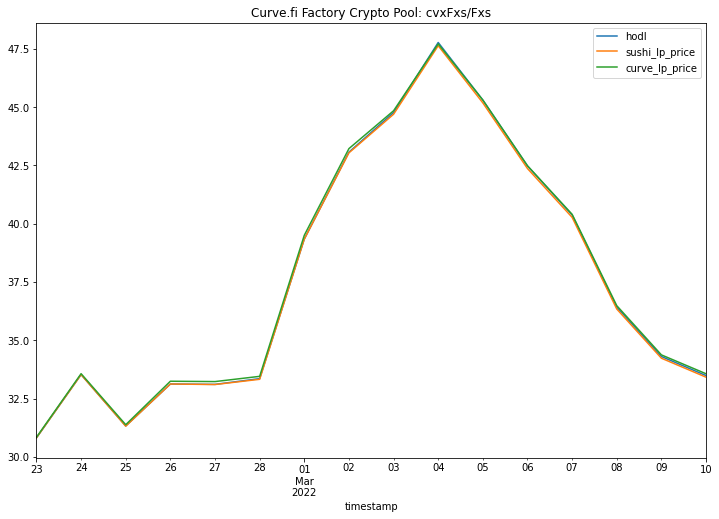

In [216]:
df[['hodl', 'sushi_lp_price', 'curve_lp_price', 'timestamp']].plot(x='timestamp', figsize=(12,8), title=data[0]['pool']['name'])